In [7]:
import copy

import matplotlib.pyplot as plt
import numpy as np
#import mitiq
from mitiq import zne
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    execute, transpile)
from qiskit import Aer
from qiskit.providers.aer import AerSimulator  , QasmSimulator
from qiskit.quantum_info import Operator
from qiskit.utils.mitigation.fitters import CompleteMeasFitter

from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

from lib import util


In [8]:
from qiskit.test.mock import FakeManila
device_backend = FakeManila()
noise_model = NoiseModel.from_backend(device_backend)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))
backend_real_jakarta = provider.get_backend('ibmq_manila')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_sim_noisy_jakarta

ibmqfactory.load_account:WARNING:2022-11-23 15:46:47,512: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
qubits_measure=[0,1]
qubits=qubits_measure
shots=10000
config=BACKEND.configuration()
N_qubits_backend=config.n_qubits

In [10]:
qr=QuantumRegister(N_qubits_backend,name='q')
qc=QuantumCircuit(qr)

qc.h(qr[0])
qc.cx(qr[0],qr[1])

#qc.h(qr[0])
#qc.measure_all()

qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
q_2: ──────────
               
q_3: ──────────
               
q_4: ──────────

In [11]:
cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc=qc,qubits_measure=qubits_measure)
cal_circs_GEM[0][0].draw()

┌────────┐┌─┐   
q__0: ┤0       ├┤M├───
      │        │└╥┘┌─┐
q__1: ┤1       ├─╫─┤M├
      │        │ ║ └╥┘
q__2: ┤2 cal_1 ├─╫──╫─
      │        │ ║  ║ 
q__3: ┤3       ├─╫──╫─
      │        │ ║  ║ 
q__4: ┤4       ├─╫──╫─
      └────────┘ ║  ║ 
 c: 2/═══════════╩══╩═
                 0  1

In [12]:
backend=backend_sim_ideal
qr = QuantumRegister(N_qubits_backend)
meas_calibs, state_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits_measure)
print(len(meas_calibs))
job_cal = execute(meas_calibs, backend=backend, shots=shots)
#job_cal.queue_position(refresh=True)
cal_results = job_cal.result()
cal_counts=cal_results.get_counts()
print(cal_counts)
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
#print(meas_fitter.cal_matrix())

4
[{'00': 10000}, {'01': 10000}, {'10': 10000}, {'11': 10000}]


In [13]:
def circs_run(circs,qcirc,backend=BACKEND,qubits=qubits,qubits_measure=qubits_measure):
    

    cal_circs_meas, s_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits_measure)
    cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc=qcirc,qubits_measure=qubits_measure)
    circs += cal_circs_meas
    print(len(cal_circs_meas))
    circs += cal_circs_GEM[0]
    print(cal_circs_GEM[0][0].count_ops())
    print(len(cal_circs_GEM[0]))
    circs += cal_circs_GEM[1]
    print(len(cal_circs_GEM[1]))
    print(cal_circs_GEM[1][0].count_ops())

    qr_aux=QuantumRegister(N_qubits_backend,name='q')
    cr=ClassicalRegister(len(qubits_measure))
    qc=QuantumCircuit(qr_aux,cr)

    qc.append(qcirc,qr_aux)
    qc=transpile(qc,backend,optimization_level=0)
    for i in range (0,len(qubits_measure)):
        qc.measure([qr_aux[qubits_measure[i]]],[cr[i]])
    circs.append(qc)

    

    return circs,s_labels


In [14]:
circs=[]
circs,s_labels=circs_run(circs,qc)
print(len(circs))
job=execute(circs,BACKEND,shots=shots,optimization_level=0)
job_result=job.result()
job_counts=job_result.get_counts()
job_qiskit=copy.deepcopy(cal_results)
job_GEM_L=copy.deepcopy(cal_results)
job_GEM_R=copy.deepcopy(cal_results)
for j in range (0,len(s_labels)):
    job_qiskit.results[j].data.counts=job_counts[j]
meas_fitter=CompleteMeasFitter(job_qiskit,s_labels)
C_qiskit=meas_fitter.cal_matrix
for j in range (0,len(s_labels)):
    job_GEM_L.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+len(s_labels)],method="least_squares")
    job_GEM_R.results[j].data.counts=meas_fitter.filter.apply(job_counts[j+2*len(s_labels)],method="least_squares")

meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
C=(Cal_GEM_L+Cal_GEM_R)/2
    
    #define the equilibrium counts distribution
rand_vec_prob=np.sum(C,axis=1,dtype='float')/(len(s_labels))
    
    
    #calculate the probaabilities of dep error
p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)
print('p_t')
print(p_t)

    #define the random prob vector and equilibrium prob vector
print('rand_vec')
print(rand_vec_prob)
rand_vec=p_t*shots*rand_vec_prob

D=np.zeros((len(s_labels),len(s_labels)))

for k in range (0,len(s_labels)):
    for j in range (0,len(s_labels)):
        D[k][j]=(C[k][j]-p_t*rand_vec_prob[k])/(1-p_t)
CGP=D
    
    
meas_fitter_GP=copy.deepcopy(meas_fitter)
meas_fitter_GP.cal_matrices=CGP

meas_fitter_GEM=copy.deepcopy(meas_fitter)
meas_fitter_GEM.cal_matrices=C



4
OrderedDict([('measure', 2), ('cal_1', 1)])
4
4
OrderedDict([('measure', 2), ('cal_2', 1)])
13
p_t
0.002965407137280914
rand_vec
[0.24950892 0.25109266 0.25163392 0.2477645 ]


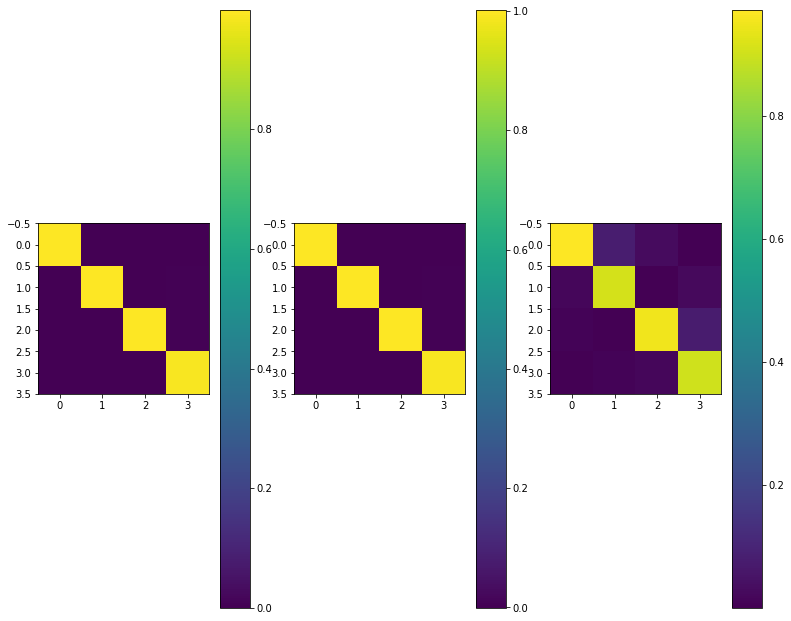

In [15]:
plt.figure(figsize=(13,11))
plt.subplot(131)
plt.imshow(C)
plt.colorbar()
plt.subplot(132)
plt.imshow(D)
plt.colorbar()
plt.subplot(133)
plt.imshow(C_qiskit)
plt.colorbar()
plt.show()

In [16]:
job_counts_circ_raw=job_counts[-1]
raw_vector=util.occurrences_to_vector(job_counts_circ_raw)
new_vector_CGP=(raw_vector-rand_vec)/(1-p_t)
new_counts=dict(zip(s_labels,new_vector_CGP))
job_counts_circ_CGP=meas_fitter_GP.filter.apply(new_counts,method="least_squares")
job_counts_circ_qiskit=meas_fitter.filter.apply(job_counts[-1],method="least_squares")
job_counts_circ_GEM=meas_fitter_GEM.filter.apply(job_counts_circ_qiskit,method="least_squares")

In [17]:
qr=QuantumRegister(N_qubits_backend)
cr=ClassicalRegister(len(qubits_measure))
qc=QuantumCircuit(qr,cr)

qc.h(qr[0])
qc.cx(qr[0],qr[1])

for i in range (0,len(qubits_measure)):
    qc.measure([qr[qubits_measure[i]]],[cr[i]])
circuit =  qc
    # Convert from raw measurement counts to the expectation value
scale_factors = [1., 2., 3.]
folded_circuits = [
     zne.scaling.fold_all(circuit, scale)
        for scale in scale_factors
]
job_zne = execute(
    experiments=folded_circuits,
    backend=BACKEND,
    optimization_level=0,  # Important to preserve folded gates.
    shots=shots,
)
    # Check that the circuit depth is (approximately) scaled as expected
#print(a)
for j, c in enumerate(folded_circuits):
    print(f"Number of gates of folded circuit {j} scaled by: {len(c) / len(circuit):.3f}")
counts_zne=np.zeros(len(s_labels))
all_counts = [job_zne.result().get_counts(i) for i in range(len(folded_circuits))]
z=np.zeros(len(s_labels))
for i in range (0,len(s_labels)):
    string=s_labels[i]
    expectation_values=[]
    for counts in all_counts:
        if string in counts:
            expectation_values.append(counts[string] / shots)
        else:
            expectation_values.append(0)
    z[i] = zne.RichardsonFactory.extrapolate(scale_factors, expectation_values)*shots

new_counts_zne=dict(zip(util.bin_list(2),z))
print(new_counts_zne)


Number of gates of folded circuit 0 scaled by: 0.571
Number of gates of folded circuit 1 scaled by: 1.000
Number of gates of folded circuit 2 scaled by: 2.429
{'00': 5078.000000000003, '01': 271.9999999999997, '10': 366.99999999999943, '11': 4282.999999999996}


In [18]:
new_counts_zne=dict(zip(util.bin_list(2),z))

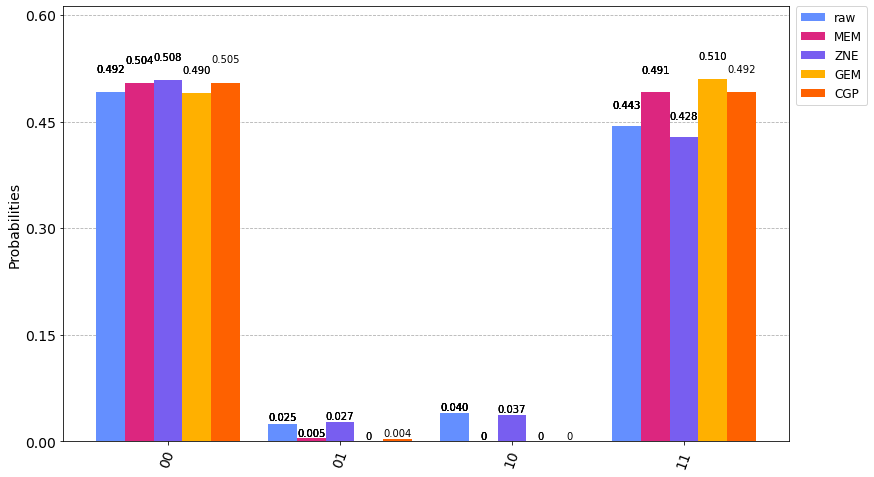

In [19]:
legend = ['raw', 'MEM','ZNE','GEM','CGP']
plot_histogram([job_counts_circ_raw, job_counts_circ_qiskit,new_counts_zne,job_counts_circ_GEM,job_counts_circ_CGP],legend=legend,figsize=(13,8))